# Лабораторная Работа "Нелинейная краевая задача"

## Задача

Решаем нелинейную краевую задачу *(XI.9.3а)*

$$\begin{cases}
y'' = x \sqrt{y}, ~0 \lt x \le 1 \\
y(0) = 0, ~y(1)=2 \\
\end{cases}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Adding ODE lab to PYTHONPATH
def update_path():
    import sys
    import os
    import pathlib

    pwd = os.getcwd()
    parent = os.path.join(*os.path.split(pwd)[:-1])
    path = os.path.join(parent, "5-6-ODE")
    sys.path.append(path)
update_path()

from solvers import RungeKuttaCollection, CALC_TYPE

Представим задачу как
$$\begin{cases}
y'' = f(x, y, y') = x \sqrt{y} \\

\frac{\partial f} {\partial y} = \frac{x}{2 \sqrt{y}} \\
\frac{\partial f} {\partial y'} = 0

\end{cases}$$

Тестировать методы будем на простой задаче:
$$\begin{cases}
y'' = -y\\
y(0) = 0, ~y(9\pi/2) = 1
\end{cases}$$

На интегральной кривой мы должны увидеть функцию $y = sin(x)$.

In [2]:
class Function:
    # f, df/dy, df/dy'
    def __init__(self, f, fdy, fdyd):
        self.f = f
        self.dy = fdy
        self.dyd = fdyd

class BoundProblem:
    def __init__(self, x1, y1, x2, y2):
        self.x1, self.x2 = x1, x2
        self.y1, self.y2 = y1, y2

# here y(0) = \epsilon << 1
# a hack to resolve uncertainty
# in df/dy(0, 0)
bp_task = BoundProblem(0, 1e-5, 1, 2)
f_task = Function(lambda x, y, yd: x*np.sqrt(y), lambda x, y, yd: x / (2 * np.sqrt(y)), lambda x, y, yd: np.zeros_like(x))

f_test = Function(lambda x, y, yd: -y, lambda x, y, yd: np.full_like(x, -1), lambda x, y, yd: np.zeros_like(x))
bp_test = BoundProblem(0, 0, 9*np.pi/2, 1)

In [3]:
def calc_err(func, X, Y, h):
    D1 = [Y[i + 1] - 2*Y[i] + Y[i-1] for i in range(1, len(Y) - 1)]
    D1 = np.array(D1, dtype=CALC_TYPE) / h**2

    Xd = X[1:-1].copy()
    Yd = Y[1:-1].copy()
    D2 = func.f(Xd, Yd, Yd)

    return Xd, np.abs(D1 - D2)

def plot_task(func, bp, solver, h, exp, title, expected = None):
    fig, (yplot, eplot) = plt.subplots(1, 2)
    X, Ys = solver(func, bp, h)
    Xd, E = calc_err(func, X, Ys[-1], h)

    yplot.plot(X, Ys[-1], label="solution")

    def calc_alpha(Ys, i):
        a = (np.exp(exp*(i)/len(Ys)) - 1) + .2
        if a > 1: a = 0
        return a

    for i, Y in enumerate(Ys[:-1]):
        yplot.plot(X, Y, "k--", alpha=calc_alpha(Ys, i), lw=1)

    print(len(Ys))

    yplot.scatter((bp.x1, bp.x2), (bp.y1, bp.y2), c="k", zorder=8)
    if expected is not None:
        yplot.plot(X, expected(X))

    eplot.plot(Xd, E)
    
    yplot.grid()
    eplot.grid()

    yplot.set_xlabel("$x$")
    yplot.set_ylabel("$y$")
    yplot.legend()

    eplot.set_xlabel("$x$")
    eplot.set_ylabel("$err$")

    yplot.set_title("Решение")
    eplot.set_title("Ошибка $err=|y''_n - f_n|$")

    fig.set_size_inches((14, 7))
    
    plt.suptitle(f"{title}\nШтрихованные линии - итерации алгоритма")
    plt.show()

## 1. Метод стрельбы

Будем реализовывать метод стрельбы через уравнение в вариациях. Исследуем задачу

$$\begin{cases}
y'' = f(x, y, y') \\
y(x_1) = y_1 \\
y(x_2) = y_2
\end{cases}$$

Находим $y(x, \alpha)$ и $u(x, \alpha) = \frac{\partial y}{\partial \alpha} (x, \alpha)$ как решения двух задач Коши:

$$\begin{cases}
y'' = f(x, y, y') \\
y(x_1) = y_1 \\
y'(x_1) = \alpha
\end{cases}$$

$$\begin{cases}
u'' = \frac{\partial f}{\partial y'}u' + \frac{\partial f}{\partial y}u\\
u(x_1) = 0 \\
u'(x_1) = 1
\end{cases}$$

Введем невязку $F(\alpha) = y(x_2, \alpha) - y_2$. Для решения краевой задачи нам необходимо решить задачу $F(\alpha) = 0$. Будем использовать метод Ньютона, причем $\frac{\partial F}{\partial \alpha}$ будет вычисляться не с помошью разностной формулы, а при помощи тождества

$$\frac{\partial F}{\partial \alpha} = \frac{\partial y}{\partial \alpha} = u(x, \alpha)$$

Итого, будем приближать $\alpha$ по схеме:

$$\alpha_{k + 1} = \alpha_{k} - \frac{F(\alpha_k)}{F'_\alpha(\alpha_k)} = \alpha_{k} - \frac{y(1, \alpha_k) - y_2}{u(1, \alpha_k)}$$

In [4]:
def shooting_method(f, bp, h, eps, alpha0 = 0):
    MAX_ITERATIONS = 1e3
    
    alpha = alpha0

    ode_solver = RungeKuttaCollection.create_e4(h)

    Xs = []
    Ys = []

    def ODE(q, x):
        y, u, yd, ud = q
        f0 = yd
        f1 = ud
        f2 = f.f(x, y, yd)
        f3 = f.dyd(x, y, yd)*ud + f.dy(x, y, yd) * u
        return np.array([f0, f1, f2, f3], dtype=CALC_TYPE)

    i = 0
    while 1:
        if i >= MAX_ITERATIONS:
            raise RuntimeError("Too much iterations")
        
        ode_solver.init_problem(ODE, bp.x1, np.array([bp.y1, 0, alpha, 1], dtype=CALC_TYPE))

        x = bp.x1
        y = None
        u = None
        Xs.append([]); Ys.append([])

        while x < bp.x2: 
            x, (y, u, _, __) = ode_solver.step()
            Xs[-1].append(x)
            Ys[-1].append(y)

        Xs[-1] = np.array(Xs[-1], dtype=CALC_TYPE)
        Ys[-1] = np.array(Ys[-1], dtype=CALC_TYPE)

        if np.abs(y - bp.y2) < eps:
            break

        alpha -= (y - bp.y2) / u
        i += 1
    
    return  Xs[0], Ys

### Валидация

2


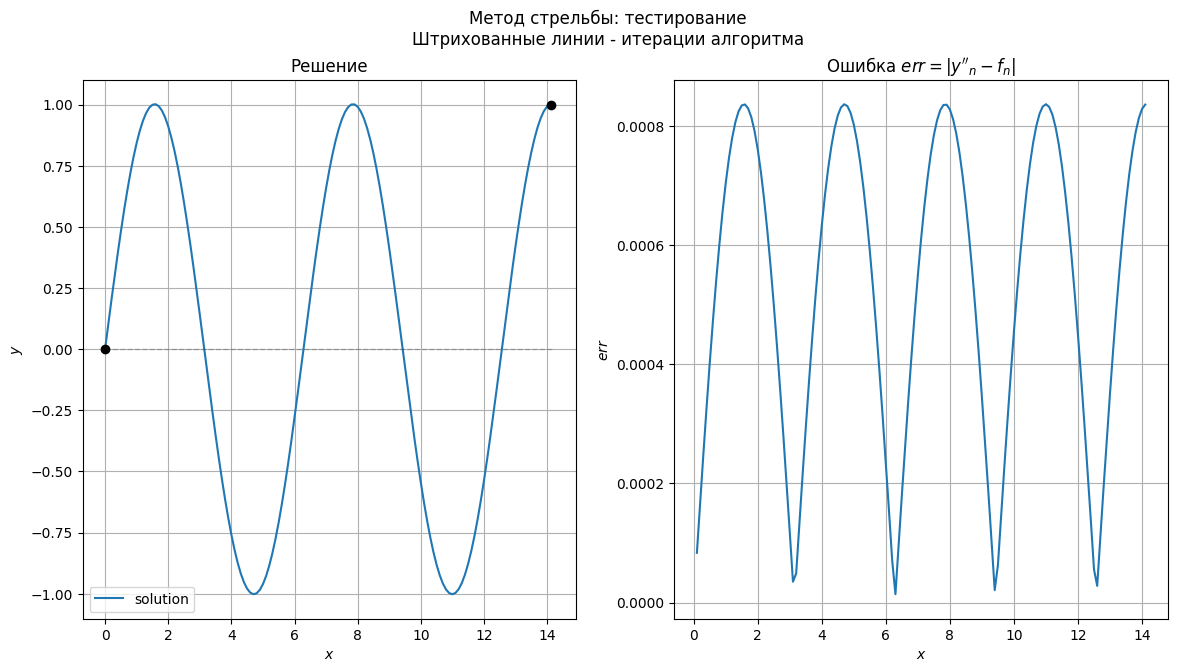

In [5]:
solver = lambda *args: shooting_method(*args, 1e-1)
plot_task(f_test, bp_test, solver, 1e-1, 1, "Метод стрельбы: тестирование")

### Решение

4


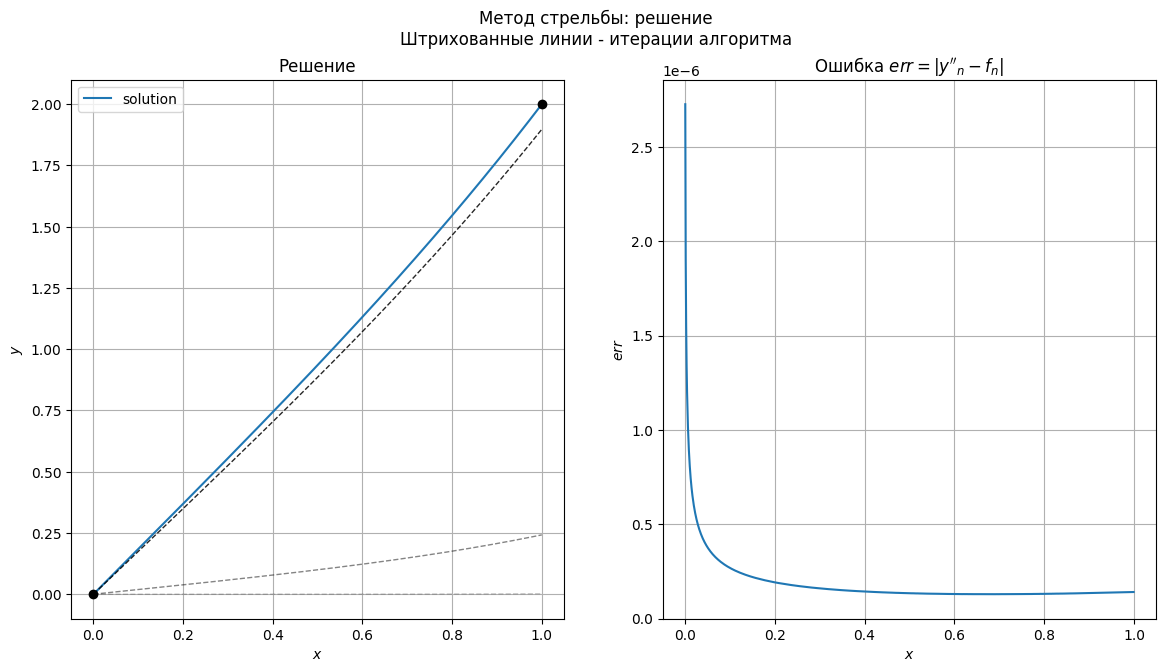

In [6]:
solver = lambda *args: shooting_method(*args, 1e-3)
plot_task(f_task, bp_task, solver, 1e-3, 1, "Метод стрельбы: решение")

## 2. Метод квазилинеаризации Ньютона

Решаем нелинейную краевую задачу

$$\begin{cases}
y'' = f(x, y, y') \\
y(x_1) = y_1 \\
y(x_2) = y_2 \\
\end{cases}$$

Для начала, необходимо подобрать нулевое приближение решения. Для этого построим прямую, удовлетворяющую граничным условиям:

$$\begin{cases}
y_0(x) = a x + b \\
y_0(x_1) = y_1 \\
y_0(x_2) = y_2 \\
\end{cases}
$$

После этого, будем итеративно приближать наше решение по следующему алгоритму:

$$\begin{cases}
y_{i + 1}(x) = y_i(x) + \nu_{i}(x) \\ 
y_{i}(x_1) = y_1,~ y_{i}(x_2) = y_2 ~ по ~индукции, \\
\nu_{i}(x_1) = \nu_{i}(x_2) = 0
\end{cases}
$$

Подставляя в исходную задачу, получим линейную краевую задачу:

$$\begin{cases}
\nu_i'' = p(x) \nu_i' + g(x) \nu + r(x),~ где \\
\nu_i(x_1) = \nu_i(x_2) = 0, \\
p(x) = \frac{\partial f}{\partial y'} (x, y_i(x), y_i'(x)), \\
g(x) = \frac{\partial f}{\partial y} (x, y_i(x), y_i'(x)), \\
r(x) = f(x, y_i(x), y_i'(x)) - y_i''
\end{cases}$$

Приблизим линейную КЗ:
$$\begin{cases}
\frac{y_{i + 1} - 2y_i + y_{i - 1}}{h^2} = p_i \frac{y_{i+1} - y_{i_1}}{2h} + g_i y_i + r_i \\
f_i := f(ih) \\
y_0 = A, ~y_{N-1} = B ~(краевые~ условия) \\
i \in [1, N-1] \\
\end{cases}$$

Получим СЛАУ с трехдиагональной матрицей относительно $Y = [y_1 ~...~ y_{N-2}]^T$:
$$\begin{cases}
y_1 \beta_1 + y_2 \gamma_1 = \delta_1 - \alpha_1 A \\
y_{i-1} \alpha_i + y_i \beta_i + \gamma_i y_{i + 1} = \delta_i, ~ i \in (2, N-2)\\
y_{N-3} \alpha_{N -2 } + y_{N -2} \beta_{N - 2} = \delta_{N-2} - \gamma_{N-2} B \\\\

\alpha_i = 1 + hp_i/2,\\
\beta_i = - 2 - h^2g_i,\\
\gamma_i = 1 - hp_i/2,\\
\delta_i = h^2r_i
\end{cases}$$

Решая эту задачу методом прогонки, получаем следующее ($y_{i+1}$) приближение. Повторяем процедуру до тех пор, пока невязка $r(x) = max|f(x, y_i(x), y_i'(x)) - y_i''(x)|$ не станет меньше желаемого $\varepsilon$.


In [7]:
def solve_tridiag(alpha, beta, gamma, delta):
    a = np.empty_like(alpha)
    b = np.empty_like(alpha)
    y = np.empty_like(alpha)

    a[1] = -gamma[0] / beta[0]
    b[1] = delta[0] / beta[0]

    for i in range(1, len(alpha) - 1):
        den = alpha[i] * a[i] + beta[i]
        a[i + 1] = - gamma[i] / den
        b[i + 1] = (delta[i] - alpha[i]*b[i]) / den

    y[-1] = (delta[-1] - alpha[-1]*b[-1]) / (alpha[-1] * a[-1] + beta[-1])

    for i in range(len(y) - 2, -1, -1):
        y[i] = a[i+1]*y[i+1] + b[i+1]
    
    return y

class ValueTable:
    def __init__(self, y, yd1, yd2):
        self.y = y
        self.yd1 = yd1
        self.yd2 = yd2

    @staticmethod
    def eval_yd1(y, h):
        return (y[2:] - y[:-2]) / (2*h)
    
    @staticmethod
    def eval_yd2(y, h):
        return (y[2:] + y[:-2] - 2*y[1:-1]) / (h**2)
    
    def reevaluate_derivatives(self, h):
        self.yd1[1:-1] = self.eval_yd1(self.y, h)
        self.yd2[1:-1] = self.eval_yd2(self.y, h)

class RFuncValueTable:
    def __init__(self, func: Function, X, val: ValueTable):
        args = X, val.y, val.yd1
        self.f = func.f(*args)
        self.dfdy = func.dy(*args)
        self.dfdyd = func.dyd(*args)

def make_linear_approximation(X, y1, y2):
    x1 = X[0]
    x2 = X[-1]

    a = (y2 - y1) / (x2 - x1)
    b = y1 - a*x1

    y = a*X + b
    yd1 = np.full_like(y, a)
    yd2 = np.zeros_like(y)

    return ValueTable(y, yd1, yd2)

def newton_method(func: Function, bp: BoundProblem, h, eps):
    x1, y1 = bp.x1, bp.y1
    x2, y2 = bp.x2, bp.y2

    X = np.arange(x1, x2+h, h, dtype=CALC_TYPE)

    y_prev = make_linear_approximation(X, y1, y2)
    f_prev = RFuncValueTable(func, X, y_prev)

    def geterr():
        return np.max(np.abs(f_prev.f - y_prev.yd2)[1:-1])

    Ys = [y_prev.y.copy()]

    while geterr() > eps:
        p = f_prev.dfdyd[1:-1]
        g = f_prev.dfdy[1:-1]
        r = (f_prev.f - y_prev.yd2)[1:-1]

        al = 1 + h*p/2
        be = -2 - h**2 * g
        ga = 1 - h*p/2
        de = r * (h**2)

        y_prev.y[1:-1] += solve_tridiag(al, be, ga, de)
        y_prev.reevaluate_derivatives(h)
        f_prev = RFuncValueTable(func, X, y_prev)

        print(geterr(), end="\r")
        Ys.append(y_prev.y.copy())
    print("\n")
    return X, Ys

### Валидация

1.2769299506665277e-14

2


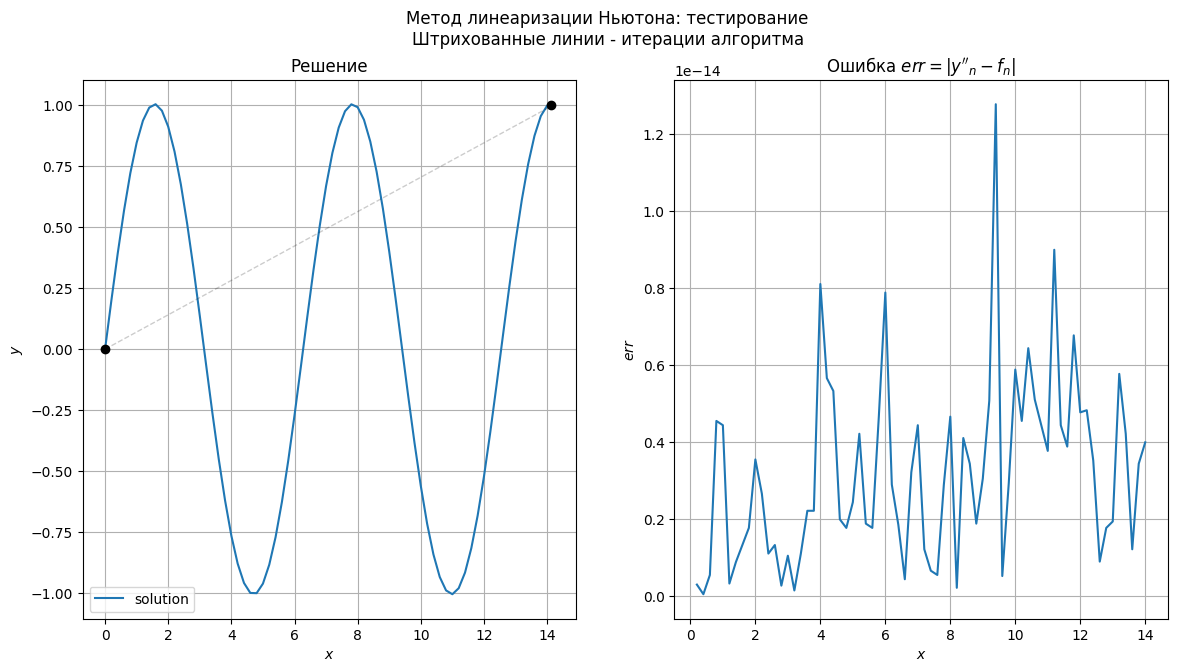

In [8]:
solver = lambda *args: newton_method(*args, 1e-2)
plot_task(f_test, bp_test, solver, .2, 1, "Метод линеаризации Ньютона: тестирование")

### Решение

4.586614421597801e-115

3


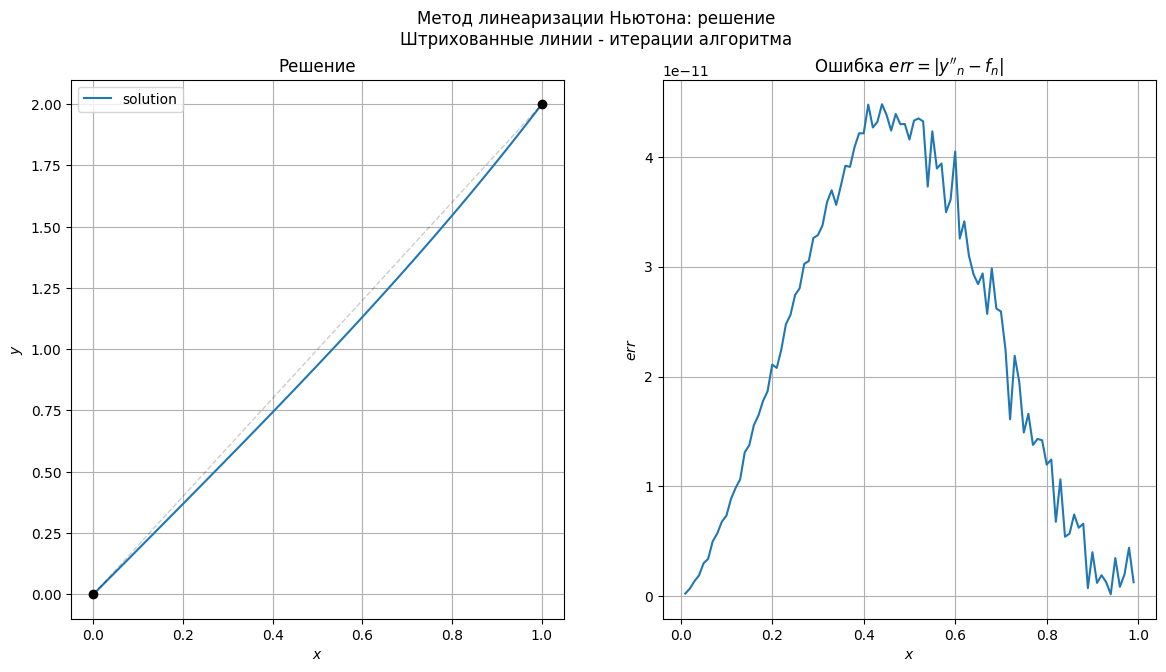

In [9]:
solver = lambda *args: newton_method(*args, 1e-4)
plot_task(f_task, bp_task, solver, 1e-2, 11, "Метод линеаризации Ньютона: решение")

# Работа 4.1 "Задача Штурма-Лиувилля"

Рассматриваем задачу XI.9.19:

$$\begin{cases}
(S(x)\psi'(x))' + \lambda^2S(x)\psi(x) = 0, ~ 0 < x < L \\
\psi'(0) = 0 \\
8\sqrt{S(L)}\psi'(L) + 3\pi\sqrt{\pi}\psi(L) = 0
\end{cases}$$

Где $S(x)$ - таблично заданная функция:

![](assets/s_table.png)

Можно заметить, что все уравнения системы - однородные. Значит, решения граничной задачи определены с точностью до нормировочного множителя. Другими словами, если $\psi(x)$ - решение, то $C \psi(x)$ - тоже решение. Поэтому, граничные условия можно дополнить нормировочным условием $\psi(0) = 1$.

Анализ размерностей показывает, что $\lambda$ имеет физический смысл пространственной угловой частоты. Тогда собстенные частоты могут быть вычислены по формуле ($c = 1193 \frac{км}{ч}$)

$$f = \frac{c \lambda}{2 \pi} \approx 54 \lambda ~кГц$$

### Интерполяция табличной функции

Проведем интерполяцию таблично заданной функции кусочно-линейным образом. Также вычислим первую производную.

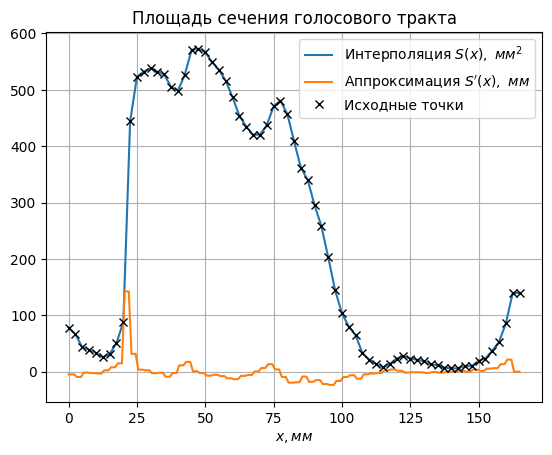

In [10]:
S_task_x = np.array([
    0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5,
    40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75,
    77.5, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 100, 102.5, 105, 107.5, 110,
    112.5, 115, 117.5, 120, 122.5, 125, 127.5, 130, 132.5, 135, 137.5, 140,
    142.5, 145, 147.5, 150, 152.5, 155, 157.5, 160, 162.5, 165
], dtype=CALC_TYPE)

S_task_val = np.array([
    78.2, 66.4, 43, 39.1, 33.2, 25.4, 31.3, 50.8, 87.7, 444, 523.2, 532.2,
    538.5, 531.7, 527.2, 504.5, 498.7, 527, 570.6, 572.5, 566.7, 549.1, 535.4,
    515.9, 486.6, 453.3, 434.8, 420, 420.7, 437.2, 470.5, 480.8, 457.2, 408.4,
    361.5, 340, 295.1, 257.9, 203.2, 144.6, 103.6, 80.1, 64.5, 33.2, 21.5, 13.7,
    7.8, 13.7, 23.4, 27.4, 23.4, 21.2, 18.5, 13, 11.3, 7.2, 5.8, 5.9, 9.8, 9.8,
    19.5, 23.4, 37.1, 52.8, 86, 139.7, 139.7
], dtype=CALC_TYPE)


def interpolate(h, xp=S_task_x, yp=S_task_val):
    X = np.arange(xp[0], xp[-1] + h, h)
    Y = np.interp(X, xp, yp)

    Yd = np.zeros_like(Y)

    Yd[0] = (-3*Y[0] + 4 * Y[1] - 1*Y[2])
    Yd[-1] = (Y[-3] -4*Y[-2] + 3*Y[-1])
    Yd[1:-1] = (Y[2:] - Y[:-2])

    return X, Y, Yd / (2 * h)

def cont_adapter(x, Xi, Yi):
    h = Xi[1] - Xi[0]
    i = ((x - Xi[0]) / h).astype(int)
    return Yi[i]

def validate_interpolation(h):
    X, Y, Yd = interpolate(h)

    plt.plot(X, cont_adapter(X, X, Y), label="Интерполяция $S(x), ~мм^2$")
    plt.plot(X, Yd, label="Аппроксимация $S'(x),~мм$")
    plt.plot(S_task_x, S_task_val, "kx", label="Исходные точки")

    plt.title("Площадь сечения голосового тракта")
    plt.grid()
    plt.legend()
    plt.xlabel("$x, мм$")


validate_interpolation(.5)

### Метод стрельбы

В отличие от предыдущей задачи, пристреливать будем параметр $\lambda$, подбирая решения $\psi(x, \lambda)$ такие, что 

$$\begin{cases}
\psi'' = - \frac{S'}{S}\psi' - \lambda^2 \psi = f(x, \psi, \psi') \\
\psi(0) = 1,~\psi'(0) = 0 \\
8\sqrt{S(L)} \psi'(L) + 3 \pi \sqrt{\pi} \psi(L) = 0
\end{cases}$$

Перейдем к уравнению в вариациях, обозначив $u = \frac{\partial \psi}{\partial \lambda}$, и решим задачу Коши:

$$\begin{cases}
\psi'' = f(x, \psi, \psi') \\
u'' = u' \frac{\partial f}{\partial \psi'} + u \frac{\partial f}{\partial \psi} + \frac{\partial f}{\partial \lambda} \\
\psi(0) = 1,~\psi'(0) = 0 \\
u(0) = u'(0) = 0
\end{cases}$$

Решая задачу Коши для произвольного $\lambda_k$, получаем $\psi(L, \lambda_k),~u(L, \lambda_k)$. Вводим невязку $F(\lambda) = 8\sqrt{S(L)} \psi'(L, \lambda) + 3 \pi \sqrt{\pi} \psi(L, \lambda) - 0$, и приближаем $\lambda$ методом Ньютона:

$$\begin{cases}
\lambda_{k+1} = \lambda_k - \frac{F(\lambda_k)}{F'_\lambda(\lambda_k)} \\
F(\lambda) = 8\sqrt{S(L)} \psi'(L, \lambda) + 3 \pi \sqrt{\pi} \psi(L, \lambda) \\
F'_\lambda(\lambda) = 8\sqrt{S(L)} u'(L, \lambda) + 3 \pi \sqrt{\pi} u(L, \lambda)
\end{cases}$$

Варьируя нулевое приближение $\lambda_0$, будем находить различные собственные значения.

In [32]:
def approximate_psi(lbda0, h, eps):
    MAX_INTERATIONS = int(1e3)
    
    Sx, S, Sd = interpolate(h)
    start = S_task_x[0]
    end = S_task_x[-1]

    def ODE(q, x, lbda):
        y, u, yd, ud = q
        
        s = cont_adapter(x, Sx, S)
        sd = cont_adapter(x, Sx, Sd)

        f0 = yd
        f1 = ud
        f2 = -(sd/s)*yd - (lbda**2) * y
        f3 = -(sd/s)*ud - (lbda**2)*u - 2*lbda*y

        return np.array([f0, f1, f2, f3], dtype=CALC_TYPE)
    
    lbda = lbda0
    solver = RungeKuttaCollection.create_e4(h)
    nsteps = int((end - start) / h)
    y, u, yd, ud = 0, 0, 0, 0

    q_start = np.array([1, 0, 0, 0], dtype=CALC_TYPE)

    def conv(a, b):
        return 8*np.sqrt(S_task_val[-1])*a + 3 * np.pi**(3/2) * b

    for _ in range(MAX_INTERATIONS):
        solver.init_problem(lambda q, x: ODE(q, x, lbda), start, q_start)

        for __ in range(nsteps):
            x, (y, u, yd, ud) = solver.step()

        print(np.abs(conv(yd, y)), end="\r")

        if np.abs(conv(yd, y)) < eps: return lbda
        lbda = np.abs(lbda - conv(yd, y)/conv(ud, u))

    raise RuntimeError("Too much iterations")

def calc_eigen_func(lbda, h):
    X = []
    Y = []

    Sx, S, Sd = interpolate(h)
    start = S_task_x[0]
    end = S_task_x[-1]


    def ODE(q, x):
        y, yd = q
        s = cont_adapter(x, Sx, S)
        sd = cont_adapter(x, Sx, Sd)

        f0 = yd
        f1 = -(sd/s)*yd - (lbda**2) * y
        return np.array([f0, f1], dtype=CALC_TYPE)
    
    solver = RungeKuttaCollection.create_e4(h)
    nsteps = int((end - start) / h)
    solver.init_problem(ODE, start, np.array([1, 0], dtype=CALC_TYPE))

    for _ in range(nsteps):
        x, (y, yd) = solver.step()
        X.append(x)
        Y.append(y)

    return np.array(X, CALC_TYPE), np.array(Y, CALC_TYPE)

def l2Hz(l): return l * 331 * 1e3 / (2 * np.pi)

def Hz2str(hz):
    if hz >= 1000:
        return f"{round(hz/1000,1)}~ kHz"
    return f"{round(hz)}~ Hz"

def l2str(l):
    return f"$\lambda={'{:.1e}'.format(l)}, ~f = {Hz2str(l2Hz(l))}$"

def find_eigen_shoot(l0, h, eps):
    l = approximate_psi(l0, h, eps)
    X, Y = calc_eigen_func(l, h)

    return l, X, Y

### Решение

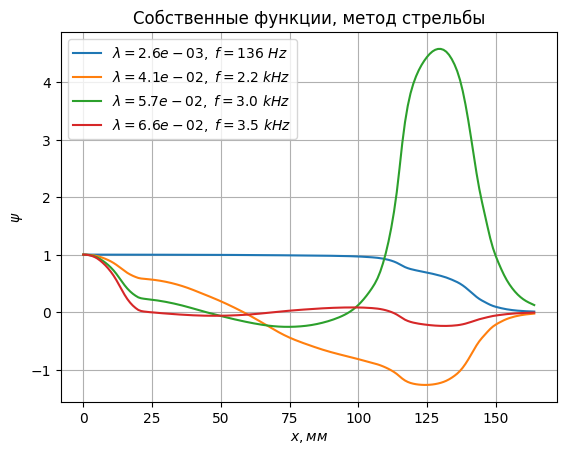

In [ ]:
h = 1
eps = 1e-6

l1 = find_eigen_shoot(1e-2, h, eps)
l2 = find_eigen_shoot(2e-2, h, eps)
l3 = find_eigen_shoot(5e-2, h, eps)
l4 = find_eigen_shoot(7e-2, h, eps)

def plot_funcs(ltups, title):
    for ltup in ltups:
        l, X, Y = ltup
        plt.plot(X, Y, label=l2str(l))

    plt.xlabel("$x, мм$")
    plt.ylabel("$\psi$")
    plt.title(title)
    plt.legend()
    plt.grid()

plot_funcs((l1, l2, l3, l4), "Собственные функции, метод стрельбы")

> Визуально интерпретировать смысл полученных функций сложно, однако собственные частоты вполне совпадают с теми, которые издает человек. Частота 135Гц находится в диапазоне фундаментальной гармоники голоса. Частоты 2-4 кГц - это т.н. верхние средние частоты, которые возникают, например, при воспроизведении шипящих согласных.

## Метод дополненного вектора

Имеем задачу
$$\begin{cases}
(S\psi')' + \lambda^2S\psi = 0, ~ 0 < x < L \\
\psi'(0) = 0 \\
8\sqrt{S(L)}\psi'(L) + 3\pi\sqrt{\pi}\psi(L) = 0
\end{cases}$$

С нормировочным условием $\psi(0) = 1$. Распишем производные в точках сетки ($x = nh, n \in [0, N]$), а также на границах, через разностные формулы. Получим систему из N + 1 уравнений:

$$
\begin{cases}
-3 \psi_0 + 4 \psi_1 - \psi_2 = 0 \\
\alpha_n \psi_{n - 1} + \beta_n \psi_n + \gamma_n \psi_{n+1} = 0, n \in [1, N-1] \\
A \psi_{N - 2} - 4A \psi_{N-1} + (3A + 2hB)\psi_N = 0 \\\\

\alpha_n = 2 - hp_n,~\beta_n = 2h^2\lambda^2 - 4,~\gamma_n = 2 + hp_n \\
p_n = S'(nh)/S(nh) \\
A = 8\sqrt{S(L)},~B=3\pi^{3/2} \\
\end{cases} 
$$

Принимая известным $\psi(0) = 1$ и взяв $\lambda$ за неизвестное, получим нелинейную систему из $N + 1$ уравнений относительно $y = [\psi_1, ..., \psi_N, \lambda]^T$ ($N+1$ неизвестных). Обозначив

$$F_n(\psi_0, y) = \begin{cases}
-3 \psi_0 + 4 y_0 - y_1, ~n=0 \\
\alpha_1 \psi_0 + \beta_1(y_N) y_0 + \gamma_1 y_1,~ n=1 \\
\alpha_n y_{n - 2} + \beta_n(y_{N}) y_{n - 1} + \gamma_n y_{n}, n \in [2, N - 1] \\
A y_{N-3} - 4A y_{N - 2} + (3A + 2hB)y_{N-1} = 0, n=N
\end{cases}
$$,

решим систему методом Ньютона:

$$y_{(s + 1)} = y_{(s)} - J_{(s)}^{-1}F(\psi_0, y_{(s)})$$

где $J_{(s)ij} = \frac{\partial F_i}{\partial y_j}(\psi_0, y_s)$. Явный вид матрицы Якоби приведен на картинке:

![](assets/jacob.png)

> P.S. Я не придумал, как оптимизировать решение системы $F(\psi_0, y_{s}) + J_{(s)}(y_{(s+1)} - y_{(s)}) = 0$ относительно $y_{(s+1)}$. Пока что решение реализовано напрямую через обращение матрицы Якоби.

In [66]:
def calc_F(y, coeffs, psi0):
    alpha, gamma, A, B, h = coeffs
    N = len(y) - 1

    beta = 2 * h**2 * y[N]**2 - 4

    F = np.empty_like(y)

    F[0] = -3 * psi0 + 4*y[0] - y[1]
    F[1] = alpha[1]*psi0 + beta * y[0] + gamma[1]*y[1]

    for n in range(2, N):
        F[n] = alpha[n]*y[n-2] + beta*y[n-1] + gamma[n]*y[n]

    F[N] = A*y[N-3] - 4*A*y[N-2] + (3*A + 2*h*B)*y[N-1]

    return F

def calc_J(y, coeffs):
    alpha, gamma, A, B, h = coeffs
    N = len(y) - 1
    J = np.zeros((N+1, N+1), dtype=CALC_TYPE)

    beta = 2 * h**2 * y[N]**2 - 4

    J[0][0], J[0][1] = 4, -1
    J[1][0], J[1][1], J[1][N] = beta, gamma[1], 4 * h**2 * y[N] * y[0]

    for n in range(2, N):
        J[n][n - 2], J[n][n - 1], J[n][n] = alpha[n], beta, gamma[n]
        J[n][N] = 4 * h**2 * y[N] * y[n - 1]
    
    J[N][N - 1] = 3*A + 2*h*B
    J[N][N - 2] = -4*A
    J[N][N - 3] = A

    return J

def augmented_vector(l0, h, eps, psi0=1):
    MAX_ITERATIONS = int(1e3)
    
    X, S, Sd = interpolate(h)
    alpha = -h*(Sd / S) + 2
    gamma = h*(Sd / S) + 2

    A = 8*np.sqrt(S[-1])
    B = 3 * np.pi**(3/2)

    y = np.full_like(X, psi0)
    y[-1] = l0

    coeffs = alpha, gamma, A, B, h

    for _ in range(MAX_ITERATIONS):
        F = calc_F(y, coeffs, psi0)
        norm = np.max(np.abs(F))

        print(norm, end="\r")

        if norm < eps:
            yret = np.empty_like(y)
            yret[0] = psi0
            yret[1:] = y[:-1]
            l = y[-1]
            return l, X, yret
        
        J = calc_J(y, coeffs)
        Jinv = np.linalg.inv(J)

        y -= Jinv @ F

        # We do not solve for lambda < 0
        # F(-lambda) = F(+lambda), therefore
        # sign flipping is a legit
        # operation
        y[-1] = np.abs(y[-1])

    raise RuntimeError("Too many iterations")

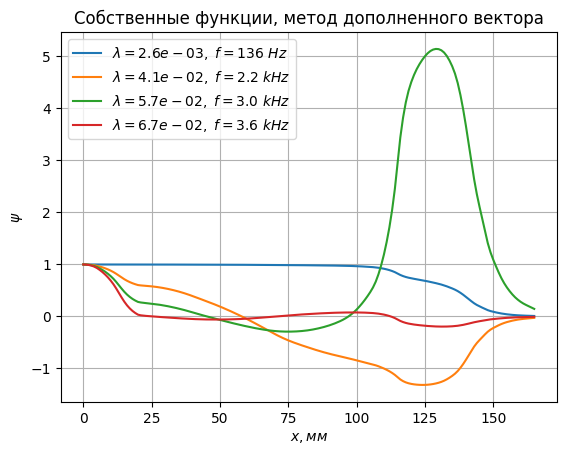

In [72]:
h = 1
eps = 1e-6

l3 = augmented_vector(9e-2, h, eps)
l4 = augmented_vector(6e-2, h, eps)
l1 = augmented_vector(3e-2, h, eps)
l2 = augmented_vector(4.1e-2, h, eps)

plot_funcs([l1, l2, l3, l4], "Собственные функции, метод дополненного вектора")

> В принципе, сошлось